In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [4]:
def normalize_position_and_rotation(samples: list[torch.tensor]) -> torch.tensor:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in samples])
    rotations = torch.stack([s[3:] for s in samples])

    # normalize position to the first sample
    positions = positions - positions[0]
    
    # normalize rotation to the first sample (remember quaternion rotations)
    new_rot = []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return torch.concatenate((positions, new_rot), axis=1)

In [5]:
def reset_position_and_rotation_to_first_node(nodes, edge_index, y):
  y = normalize_position_and_rotation(y)
  return nodes, edge_index, y

In [6]:
dataset = MultipleSequenceGraphDataset(basedir, train_sequences, transform=reset_position_and_rotation_to_first_node)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss()

In [7]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

loss_history = []
for epoch in range(150):
    model.train()
    loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch} loss: {sum(loss_history) / len(loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/model_A_{epoch}.pth")

Epoch 0:   0%|          | 0/319 [00:00<?, ?it/s]/tmp/ipykernel_175444/2837037877.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/utils/tensor_new.cpp:245.)
  new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)
Epoch 0: 100%|██████████| 319/319 [00:18<00:00, 17.14it/s, loss=8.97]


Epoch 0 loss: 4.0703803356912065


Epoch 1: 100%|██████████| 319/319 [00:18<00:00, 17.56it/s, loss=2.11]


Epoch 1 loss: 3.816700289615643


Epoch 2: 100%|██████████| 319/319 [00:17<00:00, 17.94it/s, loss=3.27]


Epoch 2 loss: 3.811433978962674


Epoch 3: 100%|██████████| 319/319 [00:18<00:00, 17.69it/s, loss=3.58]


Epoch 3 loss: 3.8080225312224


Epoch 4: 100%|██████████| 319/319 [00:18<00:00, 17.34it/s, loss=2.62]


Epoch 4 loss: 3.798921372823207


Epoch 5: 100%|██████████| 319/319 [00:18<00:00, 17.38it/s, loss=3.36]


Epoch 5 loss: 3.7965133205102903


Epoch 6: 100%|██████████| 319/319 [00:18<00:00, 17.70it/s, loss=16.8]


Epoch 6 loss: 3.8334512448983507


Epoch 7: 100%|██████████| 319/319 [00:18<00:00, 17.17it/s, loss=2.57]


Epoch 7 loss: 3.7775753572069366


Epoch 8: 100%|██████████| 319/319 [00:18<00:00, 17.48it/s, loss=2.25]


Epoch 8 loss: 3.7510197513903196


Epoch 9: 100%|██████████| 319/319 [00:18<00:00, 17.65it/s, loss=3.15]


Epoch 9 loss: 3.7989601173370984


Epoch 10: 100%|██████████| 319/319 [00:17<00:00, 17.82it/s, loss=3.24]


Epoch 10 loss: 3.7909807007888268


Epoch 11: 100%|██████████| 319/319 [00:18<00:00, 17.69it/s, loss=4.68]


Epoch 11 loss: 3.770163653412583


Epoch 12: 100%|██████████| 319/319 [00:17<00:00, 17.75it/s, loss=1.74]


Epoch 12 loss: 3.746793749937817


Epoch 13: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=5.23]


Epoch 13 loss: 3.80086533776645


Epoch 14: 100%|██████████| 319/319 [00:17<00:00, 18.06it/s, loss=2.77]


Epoch 14 loss: 3.7870257562230747


Epoch 15: 100%|██████████| 319/319 [00:17<00:00, 17.78it/s, loss=1.8] 


Epoch 15 loss: 3.777875546751351


Epoch 16: 100%|██████████| 319/319 [00:17<00:00, 18.03it/s, loss=3.04]


Epoch 16 loss: 3.76432601710472


Epoch 17: 100%|██████████| 319/319 [00:17<00:00, 17.92it/s, loss=3.03]


Epoch 17 loss: 3.7980665443085577


Epoch 18: 100%|██████████| 319/319 [00:17<00:00, 18.02it/s, loss=1.53]


Epoch 18 loss: 3.775744838400694


Epoch 19: 100%|██████████| 319/319 [00:17<00:00, 17.93it/s, loss=2.68]


Epoch 19 loss: 3.7874017628756436


Epoch 20: 100%|██████████| 319/319 [00:17<00:00, 17.87it/s, loss=3.94]


Epoch 20 loss: 3.7602967079904013


Epoch 21: 100%|██████████| 319/319 [00:17<00:00, 17.88it/s, loss=11.9]


Epoch 21 loss: 3.7641768675986502


Epoch 22: 100%|██████████| 319/319 [00:17<00:00, 18.02it/s, loss=2.63]


Epoch 22 loss: 3.711492434190732


Epoch 23: 100%|██████████| 319/319 [00:17<00:00, 17.97it/s, loss=2.98]


Epoch 23 loss: 3.567991836691351


Epoch 24: 100%|██████████| 319/319 [00:17<00:00, 17.86it/s, loss=2.63]


Epoch 24 loss: 3.655260466482946


Epoch 25: 100%|██████████| 319/319 [00:17<00:00, 17.84it/s, loss=3.54]


Epoch 25 loss: 3.5252881520967874


Epoch 26: 100%|██████████| 319/319 [00:18<00:00, 17.26it/s, loss=2.54]


Epoch 26 loss: 3.213670049341495


Epoch 27: 100%|██████████| 319/319 [00:18<00:00, 17.31it/s, loss=2.04]


Epoch 27 loss: 3.1082928730028923


Epoch 28: 100%|██████████| 319/319 [00:18<00:00, 17.70it/s, loss=2.81]


Epoch 28 loss: 3.0943387470275256


Epoch 29: 100%|██████████| 319/319 [00:18<00:00, 17.47it/s, loss=3.1] 


Epoch 29 loss: 3.0653993567702913


Epoch 30: 100%|██████████| 319/319 [00:17<00:00, 17.73it/s, loss=1.87]


Epoch 30 loss: 3.0254197385991253


Epoch 31: 100%|██████████| 319/319 [00:17<00:00, 17.79it/s, loss=2.61]


Epoch 31 loss: 3.0226389240695393


Epoch 32: 100%|██████████| 319/319 [00:17<00:00, 18.06it/s, loss=1.17]


Epoch 32 loss: 2.9635286473181552


Epoch 33: 100%|██████████| 319/319 [00:17<00:00, 17.92it/s, loss=1.59]


Epoch 33 loss: 2.94730178951096


Epoch 34: 100%|██████████| 319/319 [00:17<00:00, 17.91it/s, loss=11.6]


Epoch 34 loss: 3.4408567075071663


Epoch 35: 100%|██████████| 319/319 [00:17<00:00, 17.95it/s, loss=2.08]


Epoch 35 loss: 3.006152563334259


Epoch 36: 100%|██████████| 319/319 [00:17<00:00, 18.03it/s, loss=2.23]


Epoch 36 loss: 2.9515070661108322


Epoch 37: 100%|██████████| 319/319 [00:17<00:00, 17.91it/s, loss=2.02]


Epoch 37 loss: 2.8932579568934664


Epoch 38: 100%|██████████| 319/319 [00:17<00:00, 17.99it/s, loss=1.91]


Epoch 38 loss: 2.8660134794570062


Epoch 39: 100%|██████████| 319/319 [00:17<00:00, 17.86it/s, loss=1.83]


Epoch 39 loss: 2.8531793441892046


Epoch 40: 100%|██████████| 319/319 [00:17<00:00, 18.09it/s, loss=1.77]


Epoch 40 loss: 2.8190370857902454


Epoch 41: 100%|██████████| 319/319 [00:17<00:00, 17.84it/s, loss=1.83]


Epoch 41 loss: 2.8343555161198104


Epoch 42: 100%|██████████| 319/319 [00:17<00:00, 17.97it/s, loss=2.09]


Epoch 42 loss: 2.8043714395511112


Epoch 43: 100%|██████████| 319/319 [00:17<00:00, 17.90it/s, loss=11.6]


Epoch 43 loss: 2.8355466119921693


Epoch 44: 100%|██████████| 319/319 [00:17<00:00, 17.86it/s, loss=2.21]


Epoch 44 loss: 2.768306416777608


Epoch 45: 100%|██████████| 319/319 [00:17<00:00, 17.93it/s, loss=1.75]


Epoch 45 loss: 2.8376223330961126


Epoch 46: 100%|██████████| 319/319 [00:17<00:00, 17.80it/s, loss=1.45]


Epoch 46 loss: 2.764341365954719


Epoch 47: 100%|██████████| 319/319 [00:17<00:00, 17.92it/s, loss=2.49]


Epoch 47 loss: 2.75608571532378


Epoch 48: 100%|██████████| 319/319 [00:17<00:00, 17.94it/s, loss=1.56]


Epoch 48 loss: 2.7344786436953887


Epoch 49: 100%|██████████| 319/319 [00:17<00:00, 18.03it/s, loss=2.08]


Epoch 49 loss: 2.7352675636733963


Epoch 50: 100%|██████████| 319/319 [00:17<00:00, 17.87it/s, loss=1.88]


Epoch 50 loss: 2.73879369523458


Epoch 51: 100%|██████████| 319/319 [00:17<00:00, 17.95it/s, loss=2.37]


Epoch 51 loss: 2.7116010704758025


Epoch 52: 100%|██████████| 319/319 [00:17<00:00, 17.75it/s, loss=5.04]


Epoch 52 loss: 2.7235150703442135


Epoch 53: 100%|██████████| 319/319 [00:17<00:00, 17.90it/s, loss=1.53]


Epoch 53 loss: 2.707807525198288


Epoch 54: 100%|██████████| 319/319 [00:17<00:00, 18.07it/s, loss=1.54]


Epoch 54 loss: 2.7086218920621006


Epoch 55: 100%|██████████| 319/319 [00:17<00:00, 17.93it/s, loss=1.84]


Epoch 55 loss: 2.7014318386962795


Epoch 56: 100%|██████████| 319/319 [00:17<00:00, 18.05it/s, loss=1.49]


Epoch 56 loss: 2.6728666785368724


Epoch 57: 100%|██████████| 319/319 [00:17<00:00, 17.99it/s, loss=1.42]


Epoch 57 loss: 2.6692367777181643


Epoch 58: 100%|██████████| 319/319 [00:18<00:00, 17.65it/s, loss=5.19]


Epoch 58 loss: 2.693840974550636


Epoch 59: 100%|██████████| 319/319 [00:18<00:00, 17.29it/s, loss=1.2] 


Epoch 59 loss: 2.652448328311167


Epoch 60: 100%|██████████| 319/319 [00:19<00:00, 16.41it/s, loss=1.19]


Epoch 60 loss: 2.6528573563106383


Epoch 61: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=2.03]


Epoch 61 loss: 2.655121579439289


Epoch 62: 100%|██████████| 319/319 [00:18<00:00, 17.57it/s, loss=1.46]


Epoch 62 loss: 2.649693615757933


Epoch 63: 100%|██████████| 319/319 [00:18<00:00, 17.53it/s, loss=1.19]


Epoch 63 loss: 2.70942923267807


Epoch 64: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=1.23]


Epoch 64 loss: 2.6444903387918743


Epoch 65: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=1.41]


Epoch 65 loss: 2.6272552506677034


Epoch 66: 100%|██████████| 319/319 [00:18<00:00, 17.46it/s, loss=1.82]


Epoch 66 loss: 2.6215455554495786


Epoch 67: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=1.55]


Epoch 67 loss: 2.614105420800212


Epoch 68: 100%|██████████| 319/319 [00:18<00:00, 17.43it/s, loss=1.2] 


Epoch 68 loss: 2.6168438211130125


Epoch 69: 100%|██████████| 319/319 [00:18<00:00, 17.65it/s, loss=2.03]


Epoch 69 loss: 2.6150658052169415


Epoch 70: 100%|██████████| 319/319 [00:18<00:00, 17.50it/s, loss=1.93]


Epoch 70 loss: 2.5931067971226565


Epoch 71: 100%|██████████| 319/319 [00:18<00:00, 17.13it/s, loss=8.18]


Epoch 71 loss: 2.6422844658077325


Epoch 72: 100%|██████████| 319/319 [00:18<00:00, 16.86it/s, loss=2.02]


Epoch 72 loss: 2.5926881064441885


Epoch 73: 100%|██████████| 319/319 [00:18<00:00, 17.49it/s, loss=1.76]


Epoch 73 loss: 2.5906421992472346


Epoch 74: 100%|██████████| 319/319 [00:17<00:00, 17.87it/s, loss=2.44]  


Epoch 74 loss: 6.839981779409427


Epoch 75: 100%|██████████| 319/319 [00:17<00:00, 17.90it/s, loss=2.44]


Epoch 75 loss: 3.357857219104109


Epoch 76: 100%|██████████| 319/319 [00:19<00:00, 16.29it/s, loss=1.65]


Epoch 76 loss: 3.110228082976745


Epoch 77: 100%|██████████| 319/319 [00:18<00:00, 17.44it/s, loss=2.41]


Epoch 77 loss: 2.9537731719241247


Epoch 78: 100%|██████████| 319/319 [00:18<00:00, 17.53it/s, loss=1.38]


Epoch 78 loss: 2.8338852773265777


Epoch 79: 100%|██████████| 319/319 [00:18<00:00, 17.68it/s, loss=4.83]


Epoch 79 loss: 2.789693925821669


Epoch 80: 100%|██████████| 319/319 [00:18<00:00, 17.29it/s, loss=1.42]


Epoch 80 loss: 2.7420062241509418


Epoch 81: 100%|██████████| 319/319 [00:18<00:00, 17.48it/s, loss=1.38]


Epoch 81 loss: 2.7200697499756528


Epoch 82: 100%|██████████| 319/319 [00:18<00:00, 17.38it/s, loss=1.56]


Epoch 82 loss: 2.7226973155449175


Epoch 83: 100%|██████████| 319/319 [00:18<00:00, 17.51it/s, loss=2.08]


Epoch 83 loss: 2.7066780392279073


Epoch 84: 100%|██████████| 319/319 [00:18<00:00, 17.45it/s, loss=2.01]


Epoch 84 loss: 2.6865507913607414


Epoch 85: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=1.87]


Epoch 85 loss: 2.6879434959268123


Epoch 86: 100%|██████████| 319/319 [00:18<00:00, 17.54it/s, loss=1.77]


Epoch 86 loss: 2.690356236266492


Epoch 87: 100%|██████████| 319/319 [00:18<00:00, 17.53it/s, loss=1.39]


Epoch 87 loss: 2.66484718076114


Epoch 88: 100%|██████████| 319/319 [00:18<00:00, 17.46it/s, loss=1.34]


Epoch 88 loss: 2.678539855353137


Epoch 89: 100%|██████████| 319/319 [00:18<00:00, 17.51it/s, loss=1.24]


Epoch 89 loss: 2.67745180825081


Epoch 90: 100%|██████████| 319/319 [00:18<00:00, 17.57it/s, loss=1.75]


Epoch 90 loss: 2.66062402575741


Epoch 91: 100%|██████████| 319/319 [00:17<00:00, 17.77it/s, loss=1.96]


Epoch 91 loss: 2.651976856318387


Epoch 92: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=2.06]


Epoch 92 loss: 2.642986602544037


Epoch 93: 100%|██████████| 319/319 [00:18<00:00, 17.44it/s, loss=8.52]


Epoch 93 loss: 2.6629928533560054


Epoch 94: 100%|██████████| 319/319 [00:18<00:00, 17.60it/s, loss=1.58]


Epoch 94 loss: 2.6414018267748123


Epoch 95: 100%|██████████| 319/319 [00:18<00:00, 17.65it/s, loss=2.02]


Epoch 95 loss: 2.626798505693394


Epoch 96: 100%|██████████| 319/319 [00:18<00:00, 17.58it/s, loss=7.88]


Epoch 96 loss: 2.63168814002907


Epoch 97: 100%|██████████| 319/319 [00:18<00:00, 17.65it/s, loss=1.56]


Epoch 97 loss: 2.645083164720326


Epoch 98: 100%|██████████| 319/319 [00:18<00:00, 17.67it/s, loss=1.42]


Epoch 98 loss: 2.616431084172479


Epoch 99: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=1.64]


Epoch 99 loss: 2.6046305935958336


Epoch 100: 100%|██████████| 319/319 [00:18<00:00, 17.63it/s, loss=2.18]


Epoch 100 loss: 2.602166140714783


Epoch 101: 100%|██████████| 319/319 [00:17<00:00, 17.81it/s, loss=1.75]


Epoch 101 loss: 2.605556118824639


Epoch 102: 100%|██████████| 319/319 [00:18<00:00, 17.71it/s, loss=1.85]


Epoch 102 loss: 2.640509264596204


Epoch 103: 100%|██████████| 319/319 [00:18<00:00, 17.53it/s, loss=1.35]


Epoch 103 loss: 2.5734874794849407


Epoch 104: 100%|██████████| 319/319 [00:18<00:00, 17.68it/s, loss=1.43]


Epoch 104 loss: 2.575031011082162


Epoch 105: 100%|██████████| 319/319 [00:18<00:00, 17.54it/s, loss=1.31]


Epoch 105 loss: 2.569564702368829


Epoch 106: 100%|██████████| 319/319 [00:18<00:00, 17.68it/s, loss=5]   


Epoch 106 loss: 2.5588387120106377


Epoch 107: 100%|██████████| 319/319 [00:18<00:00, 17.43it/s, loss=1.32]


Epoch 107 loss: 2.564632862712896


Epoch 108: 100%|██████████| 319/319 [00:18<00:00, 17.59it/s, loss=0.947]


Epoch 108 loss: 2.5489811153621136


Epoch 109: 100%|██████████| 319/319 [00:18<00:00, 17.49it/s, loss=1.3] 


Epoch 109 loss: 2.5293038975108755


Epoch 110: 100%|██████████| 319/319 [00:18<00:00, 17.64it/s, loss=1.35]


Epoch 110 loss: 2.522428185588514


Epoch 111: 100%|██████████| 319/319 [00:18<00:00, 17.45it/s, loss=1.56]


Epoch 111 loss: 2.5100852938655027


Epoch 112: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=2.56]


Epoch 112 loss: 2.497927017346445


Epoch 113: 100%|██████████| 319/319 [00:18<00:00, 17.39it/s, loss=1.85]


Epoch 113 loss: 2.4735823813650675


Epoch 114: 100%|██████████| 319/319 [00:18<00:00, 17.44it/s, loss=1.47]


Epoch 114 loss: 2.463646820720087


Epoch 115: 100%|██████████| 319/319 [00:18<00:00, 17.54it/s, loss=1.36]


Epoch 115 loss: 2.4439359140994035


Epoch 116: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=1.33]


Epoch 116 loss: 2.4102093702573386


Epoch 117: 100%|██████████| 319/319 [00:19<00:00, 16.78it/s, loss=0.843]


Epoch 117 loss: 2.435459081468911


Epoch 118: 100%|██████████| 319/319 [00:18<00:00, 17.31it/s, loss=1.04]


Epoch 118 loss: 2.3988699856970377


Epoch 119: 100%|██████████| 319/319 [00:18<00:00, 17.40it/s, loss=1.27]


Epoch 119 loss: 2.3821398942821825


Epoch 120: 100%|██████████| 319/319 [00:18<00:00, 17.27it/s, loss=1.64] 


Epoch 120 loss: 2.3593655194982093


Epoch 121: 100%|██████████| 319/319 [00:18<00:00, 17.18it/s, loss=4.43]


Epoch 121 loss: 2.382376051621751


Epoch 122: 100%|██████████| 319/319 [00:18<00:00, 17.28it/s, loss=1.17]


Epoch 122 loss: 2.34773826729915


Epoch 123: 100%|██████████| 319/319 [00:18<00:00, 17.50it/s, loss=2.92]


Epoch 123 loss: 3.5465744195686986


Epoch 124: 100%|██████████| 319/319 [00:18<00:00, 17.36it/s, loss=1.46]


Epoch 124 loss: 3.060420658521144


Epoch 125: 100%|██████████| 319/319 [00:18<00:00, 17.17it/s, loss=2]   


Epoch 125 loss: 2.943293973196263


Epoch 126: 100%|██████████| 319/319 [00:18<00:00, 17.16it/s, loss=2.31]


Epoch 126 loss: 2.7892930003169187


Epoch 127: 100%|██████████| 319/319 [00:18<00:00, 17.10it/s, loss=1.16]


Epoch 127 loss: 2.7223739470807735


Epoch 128: 100%|██████████| 319/319 [00:18<00:00, 17.34it/s, loss=1.31]


Epoch 128 loss: 2.69575933490801


Epoch 129: 100%|██████████| 319/319 [00:18<00:00, 17.41it/s, loss=1.7] 


Epoch 129 loss: 2.6719248758214396


Epoch 130: 100%|██████████| 319/319 [00:18<00:00, 17.29it/s, loss=1.67]


Epoch 130 loss: 2.617988608847591


Epoch 131: 100%|██████████| 319/319 [00:18<00:00, 17.32it/s, loss=1.59]


Epoch 131 loss: 2.614992830820592


Epoch 132: 100%|██████████| 319/319 [00:18<00:00, 17.18it/s, loss=1.96]


Epoch 132 loss: 2.5843716699127866


Epoch 133: 100%|██████████| 319/319 [00:18<00:00, 17.70it/s, loss=2.45]


Epoch 133 loss: 2.5981795417851417


Epoch 134: 100%|██████████| 319/319 [00:18<00:00, 17.57it/s, loss=2.18]


Epoch 134 loss: 2.567084472381209


Epoch 135: 100%|██████████| 319/319 [00:18<00:00, 17.17it/s, loss=1.68]


Epoch 135 loss: 2.5578215544500322


Epoch 136: 100%|██████████| 319/319 [00:18<00:00, 17.46it/s, loss=1.4] 


Epoch 136 loss: 2.5637853276393257


Epoch 137: 100%|██████████| 319/319 [00:18<00:00, 17.27it/s, loss=1.23]


Epoch 137 loss: 2.61664775621181


Epoch 138: 100%|██████████| 319/319 [00:18<00:00, 17.32it/s, loss=1.14]


Epoch 138 loss: 2.5680480377053767


Epoch 139: 100%|██████████| 319/319 [00:18<00:00, 17.52it/s, loss=1.69]


Epoch 139 loss: 2.552451380741634


Epoch 140: 100%|██████████| 319/319 [00:18<00:00, 17.51it/s, loss=1.53]


Epoch 140 loss: 2.6248975480238097


Epoch 141: 100%|██████████| 319/319 [00:18<00:00, 17.52it/s, loss=1.68]


Epoch 141 loss: 2.5444411327098977


Epoch 142: 100%|██████████| 319/319 [00:18<00:00, 17.49it/s, loss=1.29]


Epoch 142 loss: 2.5482062886127483


Epoch 143: 100%|██████████| 319/319 [00:17<00:00, 17.78it/s, loss=1.66]


Epoch 143 loss: 2.526460442423447


Epoch 144: 100%|██████████| 319/319 [00:18<00:00, 17.62it/s, loss=1.88]


Epoch 144 loss: 2.522117834479831


Epoch 145: 100%|██████████| 319/319 [00:18<00:00, 17.35it/s, loss=1.84]


Epoch 145 loss: 2.495411258879874


Epoch 146: 100%|██████████| 319/319 [00:18<00:00, 17.64it/s, loss=1.49]


Epoch 146 loss: 2.4937965952116867


Epoch 147: 100%|██████████| 319/319 [00:18<00:00, 17.51it/s, loss=1.8] 


Epoch 147 loss: 2.6048961765713825


Epoch 148: 100%|██████████| 319/319 [00:18<00:00, 17.55it/s, loss=2.1] 


Epoch 148 loss: 2.5772047992036633


Epoch 149: 100%|██████████| 319/319 [00:18<00:00, 17.54it/s, loss=2.43]

Epoch 149 loss: 2.5532432809518797


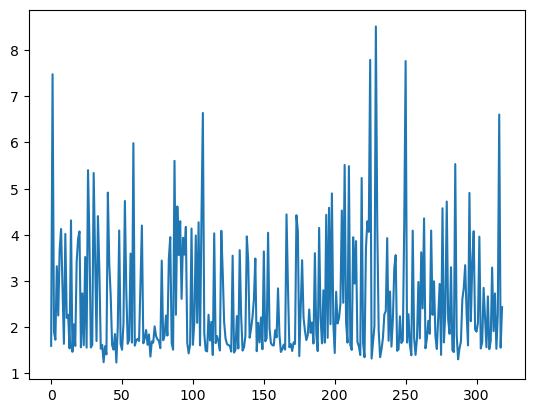

In [9]:
# plot loss
plt.plot(loss_history)
plt.show()